Processing BENIGN training files...
Processing: Benignprocessed.log
  Added 1931 windows
Processing: normal_run_data_converted.log
  Added 5065 windows
Processing: Attack_free_dataset_converted.log
  Added 10376 windows
Processing: Pre_train_benign_training_data.log
  Added 748 windows

Total benign windows for training: 18120
Features shape: (18120, 19)

Training windows: 14496
Validation windows: 3624

Input dimension: 19

Training autoencoder...
Epoch 1/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 32.5047 - val_loss: 1.4037
Epoch 2/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1227 - val_loss: 1.2966
Epoch 3/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0733 - val_loss: 1.0173
Epoch 4/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1160 - val_loss: 0.7847
Epoch 5/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0719 - val_loss: 0.7335
Epoch 6/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0496 - val_loss: 0.6536
Epoch 7/100
453/453 ━━━━

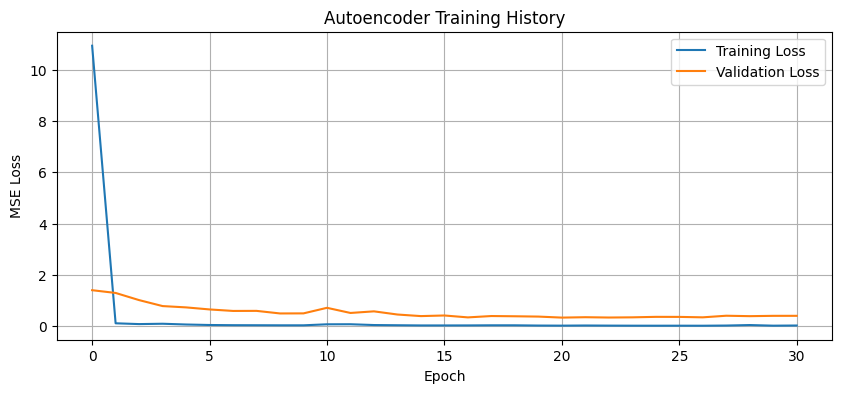


Anomaly threshold (99.5th percentile): 2.309062
Min error: 0.000936, Max error: 27.910211


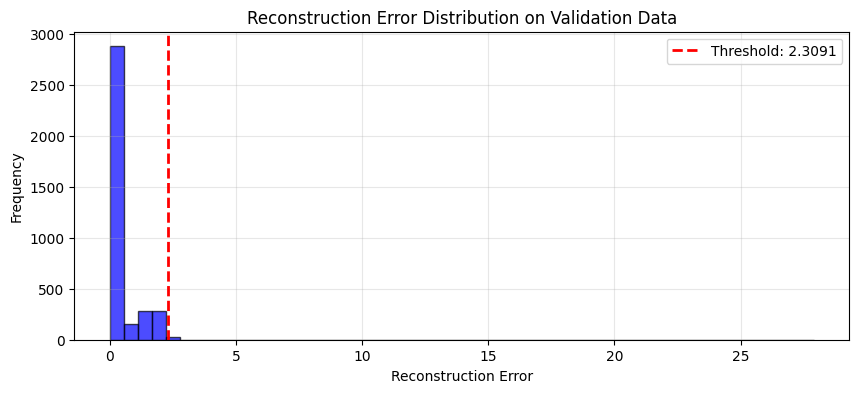


Training OCSVM on latent representations...

######################################################################
 Processing: FUZZY ATTACK
######################################################################

 EVALUATING: FUZZY ATTACK
Total messages in test file: 3838860
Benign messages: 3347013, Attack messages: 491847

Extracted windows: 29464
Benign windows: 13638, Attack windows: 15826

--------------------------------------------------
AUTOENCODER RECONSTRUCTION ERROR METHOD
--------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.9863    0.9587    0.9723     13638
      Attack     0.9653    0.9886    0.9768     15826

    accuracy                         0.9747     29464
   macro avg     0.9758    0.9736    0.9746     29464
weighted avg     0.9750    0.9747    0.9747     29464


--------------------------------------------------
OCSVM LATENT SPACE METHOD
--------------------------------------------------
  

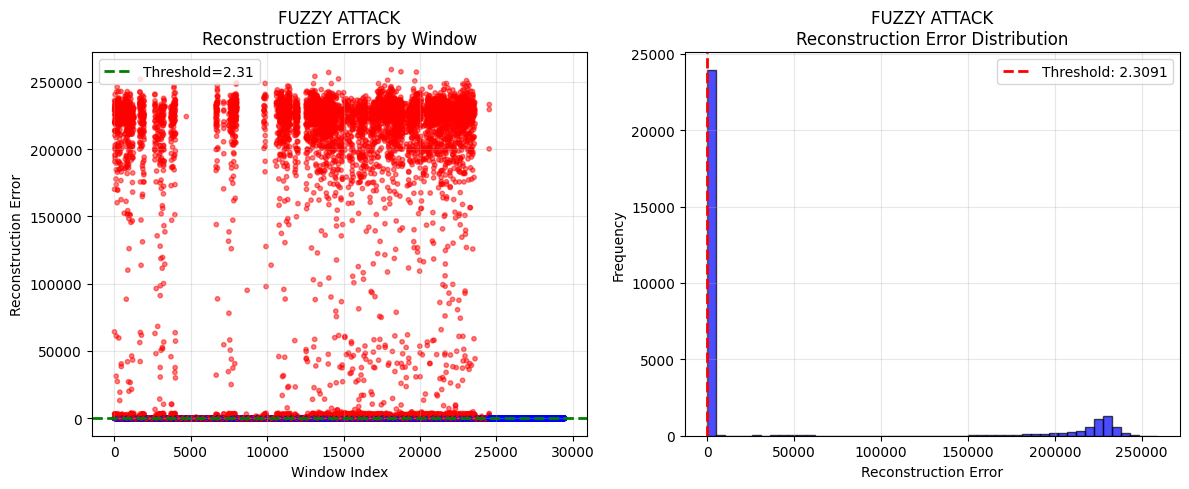


######################################################################
 Processing: DoS ATTACK
######################################################################

 EVALUATING: DoS ATTACK
Total messages in test file: 3665771
Benign messages: 3078250, Attack messages: 587521

Extracted windows: 28101
Benign windows: 14054, Attack windows: 14047

--------------------------------------------------
AUTOENCODER RECONSTRUCTION ERROR METHOD
--------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.9974    0.9450    0.9705     14054
      Attack     0.9477    0.9976    0.9720     14047

    accuracy                         0.9713     28101
   macro avg     0.9726    0.9713    0.9713     28101
weighted avg     0.9726    0.9713    0.9713     28101


--------------------------------------------------
OCSVM LATENT SPACE METHOD
--------------------------------------------------
              precision    recall  f1-score   suppo

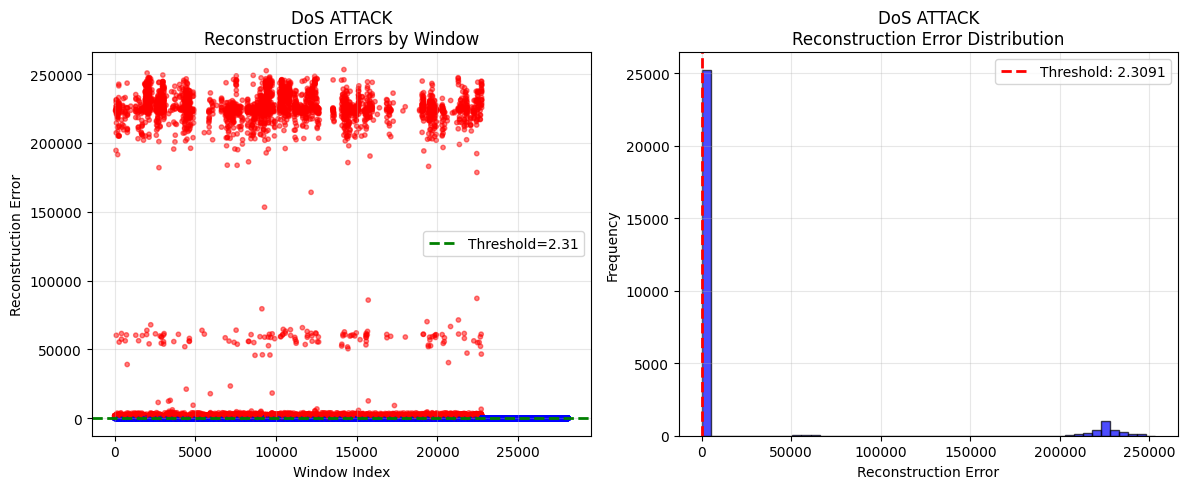


######################################################################
 Processing: RPM SPOOFING
######################################################################

 EVALUATING: RPM SPOOFING
Total messages in test file: 4621702
Benign messages: 3966805, Attack messages: 654897

Extracted windows: 24332
Benign windows: 13632, Attack windows: 10700

--------------------------------------------------
AUTOENCODER RECONSTRUCTION ERROR METHOD
--------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.9985    0.9840    0.9912     13632
      Attack     0.9800    0.9981    0.9890     10700

    accuracy                         0.9902     24332
   macro avg     0.9893    0.9911    0.9901     24332
weighted avg     0.9904    0.9902    0.9902     24332


--------------------------------------------------
OCSVM LATENT SPACE METHOD
--------------------------------------------------
              precision    recall  f1-score   s

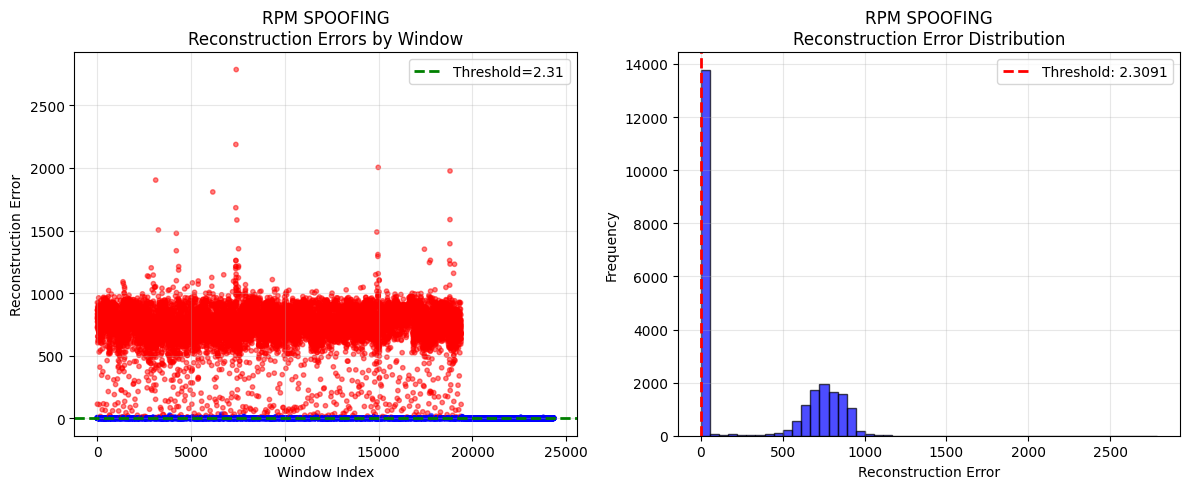


######################################################################
 Processing: GEAR INJECTION
######################################################################

 EVALUATING: GEAR INJECTION
Total messages in test file: 4443142
Benign messages: 3845890, Attack messages: 597252

Extracted windows: 24306
Benign windows: 13643, Attack windows: 10663

--------------------------------------------------
AUTOENCODER RECONSTRUCTION ERROR METHOD
--------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.9982    0.9825    0.9903     13643
      Attack     0.9780    0.9977    0.9878     10663

    accuracy                         0.9892     24306
   macro avg     0.9881    0.9901    0.9890     24306
weighted avg     0.9894    0.9892    0.9892     24306


--------------------------------------------------
OCSVM LATENT SPACE METHOD
--------------------------------------------------
              precision    recall  f1-score

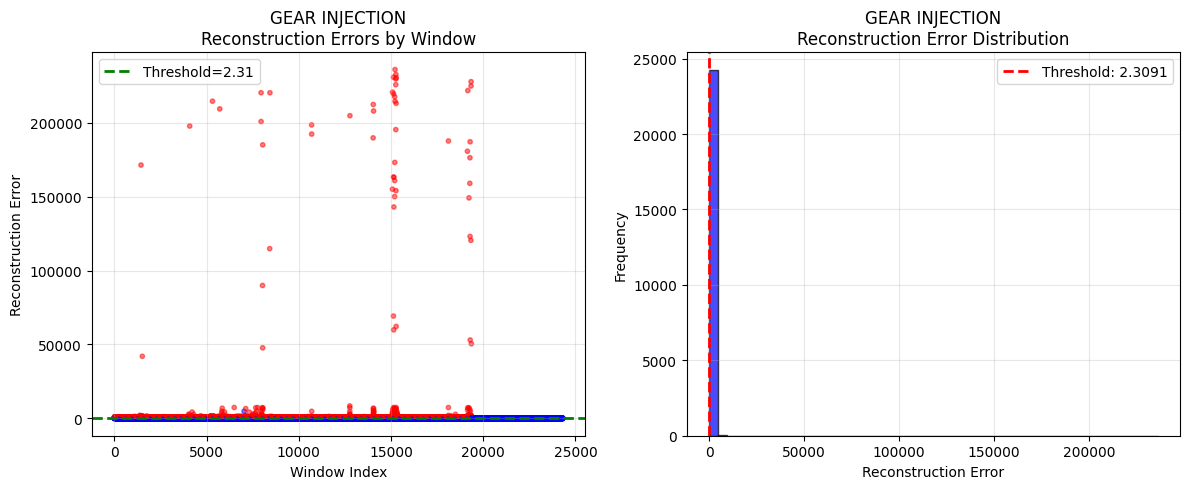


SUMMARY COMPARISON OF ALL ATTACK TYPES

   Attack Type  Total Windows  Attack Windows  Normal Windows    TP  FP    TN  FN  Accuracy  Precision  Recall  F1-Score
  FUZZY ATTACK          29464           15826           13638 15636 563 13075 190    0.9744     0.9652  0.9880    0.9765
    DoS ATTACK          28101           14047           14054 14012 773 13281  35    0.9712     0.9477  0.9975    0.9720
  RPM SPOOFING          24332           10700           13632 10680 218 13414  20    0.9902     0.9800  0.9981    0.9890
GEAR INJECTION          24306           10663           13643 10639 239 13404  24    0.9892     0.9780  0.9977    0.9878


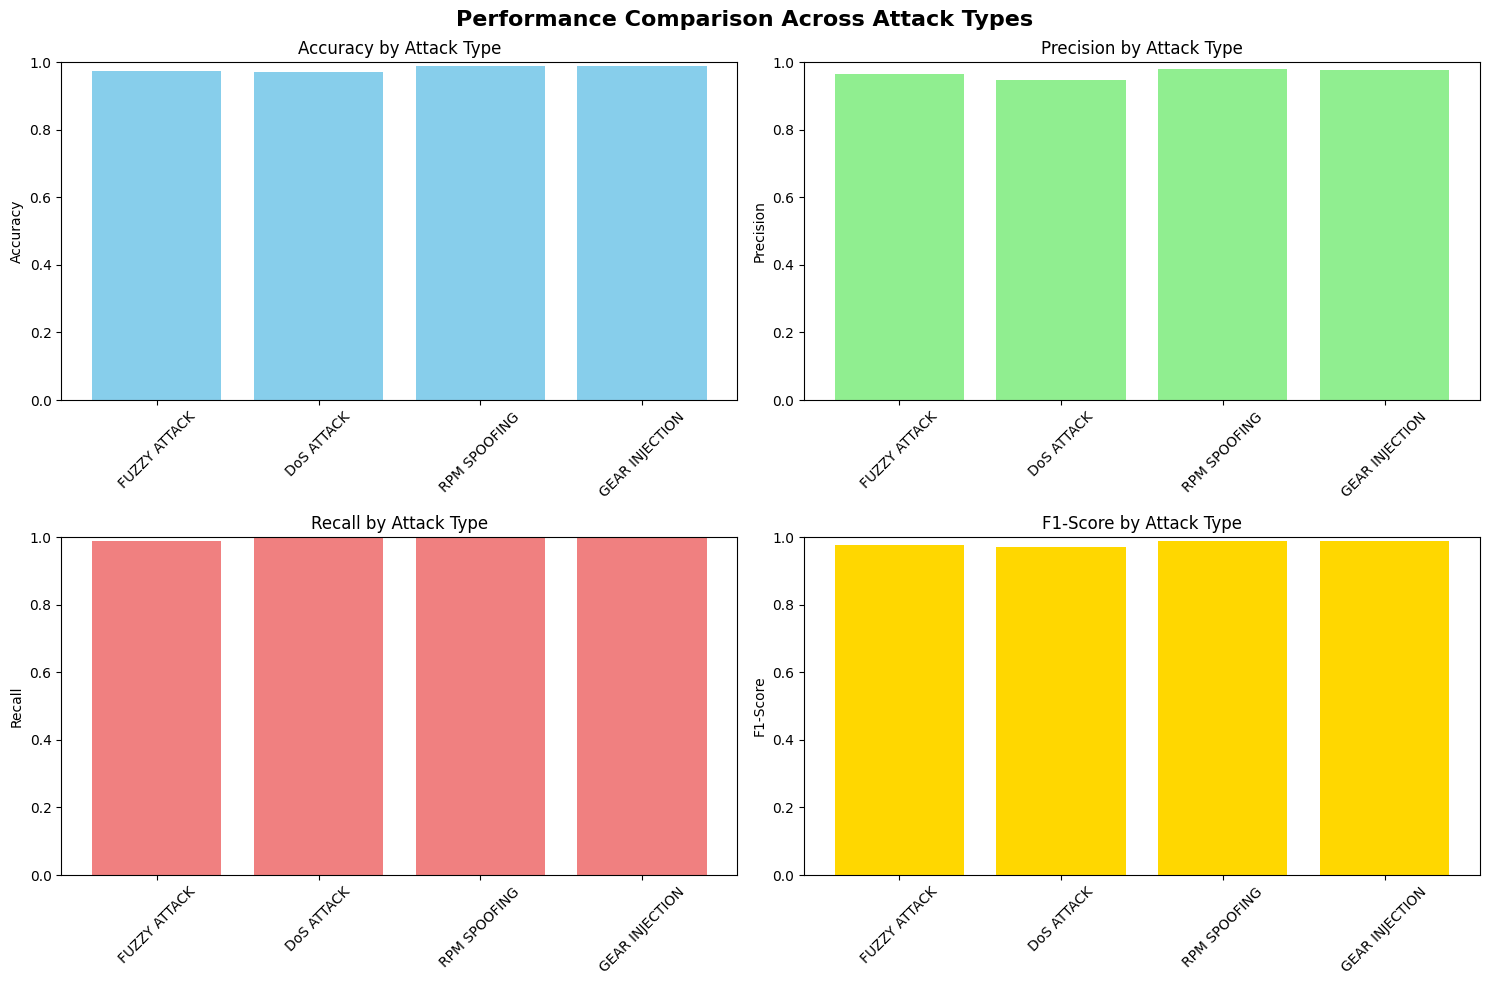

In [5]:
import pandas as pd
import numpy as np
import scipy.stats
import re
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. PARSER FUNCTIONS ---

def parse_nominal_log(filepath):
    """Parse nominal log files (only benign data)"""
    parsed_data = []
    with open(filepath, 'r') as f:
        for line in f:
            clean_line = line.replace('(', '').replace(')', '').replace('#', ' ').strip()
            parts = clean_line.split()

            if len(parts) < 2:
                continue

            try:
                ts = float(parts[0])
                raw_id = parts[2] if 'can' in parts[1].lower() else parts[1]
                can_id = int(raw_id, 16)
                parsed_data.append([ts, can_id, 0])
            except (ValueError, IndexError):
                continue

    df = pd.DataFrame(parsed_data, columns=['timestamp', 'id', 'label'])
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

def parse_labeled_csv(filepath):
    """Parse labeled CSV files with attack data"""
    parsed_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = [p.strip() for p in line.split(',')]
            if len(parts) < 4:
                continue
            try:
                ts = float(parts[0])
                can_id = int(parts[1], 16)
                flag_raw = parts[-1]
                label = 1 if flag_raw == 'T' else 0
                parsed_data.append([ts, can_id, label])
            except:
                continue

    df = pd.DataFrame(parsed_data, columns=['timestamp', 'id', 'label'])
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

# --- 2. ENHANCED FEATURE ENGINEERING ---

def calculate_entropy(ids):
    """Calculate Shannon entropy of ID distribution"""
    if len(ids) <= 1:
        return 0
    counts = pd.Series(ids).value_counts()
    return scipy.stats.entropy(counts)

def calculate_statistical_features(timestamps):
    """Calculate Inter-Arrival Time statistics"""
    if len(timestamps) <= 1:
        return 0, 0, 0, 0, 0

    diffs = timestamps.diff().dt.total_seconds().dropna()
    if len(diffs) == 0:
        return 0, 0, 0, 0, 0

    return diffs.mean(), diffs.std(), diffs.min(), diffs.max(), diffs.median()

def extract_enhanced_features(df, window_size='100ms'):
    """Extract features with proper alignment between features and labels"""
    # First, create windows based on timestamp
    df['window'] = df['timestamp'].dt.floor(window_size)

    features_list = []
    labels_list = []
    window_times = []

    # Group by windows
    for window_time, group in df.groupby('window'):
        if len(group) == 0:
            continue

        # Basic features
        msg_count = len(group)
        unique_ids = group['id'].nunique()
        id_entropy = calculate_entropy(group['id'])

        # IAT statistics
        iat_mean, iat_std, iat_min, iat_max, iat_median = calculate_statistical_features(group['timestamp'])

        # Additional features
        features = {
            'msg_count': msg_count,
            'unique_ids': unique_ids,
            'id_entropy': id_entropy,
            'iat_mean': iat_mean,
            'iat_std': iat_std,
            'iat_min': iat_min,
            'iat_max': iat_max,
            'iat_median': iat_median,
            'msg_rate': msg_count / 0.1 if window_size == '100ms' else msg_count,
        }

        # ID frequency distribution (top 5 IDs)
        id_counts = group['id'].value_counts()
        top_ids = id_counts.head(5)

        # Add top ID counts
        for i in range(5):
            col_name = f'top_id_{i+1}_count'
            if i < len(top_ids):
                features[col_name] = top_ids.iloc[i]
            else:
                features[col_name] = 0

        # Add top ID ratios
        if msg_count > 0:
            for i in range(5):
                col_name = f'top_id_{i+1}_ratio'
                if i < len(top_ids):
                    features[col_name] = top_ids.iloc[i] / msg_count
                else:
                    features[col_name] = 0
        else:
            for i in range(5):
                features[f'top_id_{i+1}_ratio'] = 0

        features_list.append(features)
        window_times.append(window_time)
        # Use max label in the window
        labels_list.append(group['label'].max())

    features_df = pd.DataFrame(features_list, index=window_times)
    labels_series = pd.Series(labels_list, index=window_times)

    return features_df, labels_series

# --- 3. DATA PREPARATION AND TRAINING ---

def prepare_benign_data(file_list):
    """Load and process only benign data for training"""
    train_features_list = []

    print("Processing BENIGN training files...")
    for f in file_list:
        print(f"Processing: {f}")
        try:
            raw_data = parse_nominal_log(f)

            if raw_data.empty:
                print(f"Warning: {f} produced no data")
                continue

            # Ensure all training data is labeled as benign (0)
            raw_data['label'] = 0

            features, labels = extract_enhanced_features(raw_data)

            # Verify no attacks in training data
            if labels.max() > 0:
                print(f"Warning: {f} contains attack labels! Skipping...")
                continue

            train_features_list.append(features)
            print(f"  Added {len(features)} windows")

        except Exception as e:
            print(f"Error processing {f}: {e}")
            continue

    if not train_features_list:
        raise ValueError("No benign data was successfully processed!")

    # Combine all benign data
    X_train_benign = pd.concat(train_features_list)
    print(f"\nTotal benign windows for training: {len(X_train_benign)}")
    print(f"Features shape: {X_train_benign.shape}")

    return X_train_benign

def train_anomaly_detector(X_train_benign):
    """Train autoencoder and OCSVM on benign data"""

    # Split benign data for validation
    X_train, X_val = train_test_split(
        X_train_benign,
        test_size=0.2,
        random_state=42,
        shuffle=False
    )

    print(f"\nTraining windows: {len(X_train)}")
    print(f"Validation windows: {len(X_val)}")

    # Scaling - Fit ONLY on training benign data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Autoencoder architecture
    input_dim = X_train_scaled.shape[1]

    print(f"\nInput dimension: {input_dim}")

    # Build autoencoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(32, activation='relu')(input_layer)
    encoded = layers.Dense(16, activation='relu')(encoded)
    latent = layers.Dense(8, activation='relu')(encoded)

    decoded = layers.Dense(16, activation='relu')(latent)
    decoded = layers.Dense(32, activation='relu')(decoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)

    autoencoder = models.Model(input_layer, output_layer)
    encoder = models.Model(input_layer, latent)

    autoencoder.compile(optimizer='adam', loss='mse')

    # Training with early stopping
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    print("\nTraining autoencoder...")
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_scaled, X_val_scaled),
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Autoencoder Training History')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Set anomaly threshold on validation data
    X_val_reconstructed = autoencoder.predict(X_val_scaled, verbose=0)
    reconstruction_errors = np.mean(np.square(X_val_scaled - X_val_reconstructed), axis=1)

    # Use 99th percentile as threshold
    threshold = np.percentile(reconstruction_errors, 99.5)
    print(f"\nAnomaly threshold (99.5th percentile): {threshold:.6f}")
    print(f"Min error: {reconstruction_errors.min():.6f}, Max error: {reconstruction_errors.max():.6f}")

    # Plot reconstruction error distribution
    plt.figure(figsize=(10, 4))
    plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Distribution on Validation Data')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Train OCSVM on latent representations
    print("\nTraining OCSVM on latent representations...")
    X_latent_train = encoder.predict(X_train_scaled, verbose=0)

    # Tune OCSVM parameters
    ocsvm = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')
    ocsvm.fit(X_latent_train)

    return scaler, autoencoder, encoder, ocsvm, threshold

def smooth_predictions(y_pred, window_size=5):
    """Apply rolling median smoothing to reduce noise"""
    return pd.Series(y_pred).rolling(
        window=window_size,
        center=True,
        min_periods=1
    ).median().astype(int)

# --- 4. EVALUATION FUNCTION ---

def evaluate_test_file(test_file_path, test_name, scaler, encoder, autoencoder, ocsvm, threshold):
    """Evaluate model on a test file with proper feature-label alignment"""
    print(f"\n{'='*60}")
    print(f" EVALUATING: {test_name}")
    print(f"{'='*60}")

    # Parse test data
    raw_test = parse_labeled_csv(test_file_path)

    if raw_test.empty:
        print("No data parsed from test file!")
        return None

    print(f"Total messages in test file: {len(raw_test)}")
    print(f"Benign messages: {(raw_test['label'] == 0).sum()}, Attack messages: {(raw_test['label'] == 1).sum()}")

    # Extract features
    X_test_windows, y_test_true = extract_enhanced_features(raw_test)

    if len(X_test_windows) == 0:
        print("No windows extracted from test file!")
        return None

    print(f"\nExtracted windows: {len(X_test_windows)}")
    print(f"Benign windows: {(y_test_true == 0).sum()}, Attack windows: {(y_test_true == 1).sum()}")

    # Scale using the SAME scaler fitted on training benign data
    X_test_scaled = scaler.transform(X_test_windows)

    # Method 1: Autoencoder reconstruction error
    X_test_reconstructed = autoencoder.predict(X_test_scaled, verbose=0)
    rec_errors = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)
    y_pred_ae = (rec_errors > threshold).astype(int)

    # Method 2: OCSVM predictions
    X_test_latent = encoder.predict(X_test_scaled, verbose=0)
    svm_preds = ocsvm.predict(X_test_latent)
    y_pred_svm = np.where(svm_preds == -1, 1, 0)  # -1 = anomaly

    # Method 3: Combined approach (AND operation - more strict)
    y_pred_combined = ((y_pred_ae == 1) & (y_pred_svm == 1)).astype(int)

    # Smooth predictions
    y_pred_ae_smooth = smooth_predictions(y_pred_ae, window_size=3)
    y_pred_svm_smooth = smooth_predictions(y_pred_svm, window_size=3)
    y_pred_combined_smooth = smooth_predictions(y_pred_combined, window_size=3)

    # Ensure all arrays have same length
    min_length = min(len(y_test_true), len(y_pred_ae_smooth), len(y_pred_svm_smooth), len(y_pred_combined_smooth))
    y_test_true = y_test_true.values[:min_length] if hasattr(y_test_true, 'values') else y_test_true[:min_length]
    y_pred_ae_smooth = y_pred_ae_smooth[:min_length]
    y_pred_svm_smooth = y_pred_svm_smooth[:min_length]
    y_pred_combined_smooth = y_pred_combined_smooth[:min_length]

    # Evaluate each method
    print("\n" + "-"*50)
    print("AUTOENCODER RECONSTRUCTION ERROR METHOD")
    print("-"*50)
    print(classification_report(y_test_true, y_pred_ae_smooth,
                                target_names=['Normal', 'Attack'],
                                zero_division=0,
                                digits=4))

    print("\n" + "-"*50)
    print("OCSVM LATENT SPACE METHOD")
    print("-"*50)
    print(classification_report(y_test_true, y_pred_svm_smooth,
                                target_names=['Normal', 'Attack'],
                                zero_division=0,
                                digits=4))

    print("\n" + "-"*50)
    print("COMBINED METHOD (AE AND OCSVM)")
    print("-"*50)
    print(classification_report(y_test_true, y_pred_combined_smooth,
                                target_names=['Normal', 'Attack'],
                                zero_division=0,
                                digits=4))

    # Calculate and display metrics
    for method_name, y_pred in [('AE', y_pred_ae_smooth),
                                ('SVM', y_pred_svm_smooth),
                                ('Combined', y_pred_combined_smooth)]:
        try:
            cm = confusion_matrix(y_test_true, y_pred)
            tn, fp, fn, tp = cm.ravel()

            print(f"\n{method_name} - Confusion Matrix:")
            print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
            print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn):.4f}")
            print(f"Precision: {tp/(tp+fp):.4f}" if (tp+fp) > 0 else "Precision: N/A")
            print(f"Recall: {tp/(tp+fn):.4f}" if (tp+fn) > 0 else "Recall: N/A")
            print(f"F1-Score: {2*tp/(2*tp+fp+fn):.4f}" if (2*tp+fp+fn) > 0 else "F1-Score: N/A")
        except:
            print(f"\n{method_name} - Could not calculate metrics")

    # Feature analysis - FIXED indexing issue
    print("\n" + "-"*50)
    print("TOP 5 FEATURES (Mean values for ALL windows)")
    print("-"*50)

    if len(X_test_windows) > 0:
        # Get overall statistics
        overall_stats = X_test_windows.describe().T[['mean', 'std', 'min', 'max']]
        print("\nOverall feature statistics:")
        print(overall_stats.head(10))

        # Compare attack vs normal windows based on true labels
        if 0 in y_test_true and 1 in y_test_true:
            # Use true labels for comparison
            attack_indices = np.where(y_test_true == 1)[0][:min(len(X_test_windows), len(y_test_true))]
            normal_indices = np.where(y_test_true == 0)[0][:min(len(X_test_windows), len(y_test_true))]

            if len(attack_indices) > 0 and len(normal_indices) > 0:
                attack_features = X_test_windows.iloc[attack_indices] if len(attack_indices) <= len(X_test_windows) else X_test_windows
                normal_features = X_test_windows.iloc[normal_indices] if len(normal_indices) <= len(X_test_windows) else X_test_windows

                print(f"\nAttack windows: {len(attack_features)}, Normal windows: {len(normal_features)}")

                # Find most differentiating features
                feature_diffs = {}
                for col in X_test_windows.columns:
                    if col in attack_features.columns and col in normal_features.columns:
                        if len(attack_features[col]) > 0 and len(normal_features[col]) > 0:
                            diff = abs(attack_features[col].mean() - normal_features[col].mean())
                            feature_diffs[col] = diff

                if feature_diffs:
                    # Sort by largest difference
                    sorted_diffs = sorted(feature_diffs.items(), key=lambda x: x[1], reverse=True)[:5]

                    print("\nTop 5 differentiating features (Attack vs Normal - TRUE labels):")
                    for feature, diff in sorted_diffs:
                        print(f"{feature:20s}: Attack={attack_features[feature].mean():8.2f} ± {attack_features[feature].std():.2f} | "
                              f"Normal={normal_features[feature].mean():8.2f} ± {normal_features[feature].std():.2f} | "
                              f"Diff={diff:8.2f}")

    # Plot reconstruction errors for this test
    plt.figure(figsize=(12, 5))

    # Scatter plot with colors based on true labels
    plt.subplot(1, 2, 1)
    colors = ['blue' if label == 0 else 'red' for label in y_test_true[:len(rec_errors)]]
    plt.scatter(range(len(rec_errors)), rec_errors, c=colors, alpha=0.5, s=10)
    plt.axhline(y=threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold={threshold:.2f}')
    plt.xlabel('Window Index')
    plt.ylabel('Reconstruction Error')
    plt.title(f'{test_name}\nReconstruction Errors by Window')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Histogram of reconstruction errors
    plt.subplot(1, 2, 2)
    plt.hist(rec_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title(f'{test_name}\nReconstruction Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'true': y_test_true,
        'ae': y_pred_ae_smooth,
        'svm': y_pred_svm_smooth,
        'combined': y_pred_combined_smooth,
        'features': X_test_windows,
        'rec_errors': rec_errors
    }

# --- 5. MAIN EXECUTION ---

def main():
    # Benign training files
    nominal_log_files = [
        "Benignprocessed.log",
        "normal_run_data_converted.log",
        "Attack_free_dataset_converted.log",
        "Pre_train_benign_training_data.log"
    ]

    # Test files
    test_files = [
        {"path": "Fuzzy_dataset.csv", "name": "FUZZY ATTACK"},
        {"path": "DoS_dataset.csv", "name": "DoS ATTACK"},
        {"path": "RPM_dataset.csv", "name": "RPM SPOOFING"},
        {"path": "gear_dataset.csv", "name": "GEAR INJECTION"}
    ]

    # Step 1: Prepare benign data
    try:
        X_train_benign = prepare_benign_data(nominal_log_files)
    except Exception as e:
        print(f"Error preparing data: {e}")
        return

    # Step 2: Train anomaly detector
    scaler, autoencoder, encoder, ocsvm, threshold = train_anomaly_detector(X_train_benign)

    # Step 3: Evaluate on test files
    all_results = {}
    for test_case in test_files:
        try:
            print(f"\n{'#'*70}")
            print(f" Processing: {test_case['name']}")
            print(f"{'#'*70}")

            results = evaluate_test_file(
                test_case['path'],
                test_case['name'],
                scaler, encoder, autoencoder, ocsvm, threshold
            )

            if results is not None:
                all_results[test_case['name']] = results
            else:
                print(f"  No results for {test_case['name']}")

        except Exception as e:
            print(f"Error evaluating {test_case['name']}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Step 4: Summary comparison
    if all_results:
        print_summary_comparison(all_results)

def print_summary_comparison(results_dict):
    """Print summary comparison of all test results"""
    print("\n" + "="*80)
    print("SUMMARY COMPARISON OF ALL ATTACK TYPES")
    print("="*80)

    summary_data = []
    for test_name, results in results_dict.items():
        # Calculate metrics for combined method
        cm = confusion_matrix(results['true'], results['combined'])
        tn, fp, fn, tp = cm.ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        summary_data.append({
            'Attack Type': test_name,
            'Total Windows': len(results['true']),
            'Attack Windows': (results['true'] == 1).sum(),
            'Normal Windows': (results['true'] == 0).sum(),
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Create summary dataframe
    summary_df = pd.DataFrame(summary_data)

    # Display summary table
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("\n" + summary_df.to_string(index=False))

    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy comparison
    axes[0, 0].bar(summary_df['Attack Type'], summary_df['Accuracy'], color='skyblue')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy by Attack Type')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Precision comparison
    axes[0, 1].bar(summary_df['Attack Type'], summary_df['Precision'], color='lightgreen')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision by Attack Type')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Recall comparison
    axes[1, 0].bar(summary_df['Attack Type'], summary_df['Recall'], color='lightcoral')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title('Recall by Attack Type')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].tick_params(axis='x', rotation=45)

    # F1-Score comparison
    axes[1, 1].bar(summary_df['Attack Type'], summary_df['F1-Score'], color='gold')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_title('F1-Score by Attack Type')
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.suptitle('Performance Comparison Across Attack Types', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()